## How to Train Your Neural Net: A Comprehensive Guide to Designing and Training Convolutional Neural Networks for Astrophysical Purposes. 
### Author: Isaac Moskowitz
### Professor Earl P. Bellinger
#### ASTR 330: Scientific Computing in Astrophysics.
#### Final Project.

## Introduction

In the past few years, machine learning and artificial intelligence have become incredibly useful and popular tools for scientific analysis, serving as a type of virtual research assistant that can probe and analyze large datasets to assist and help advance human scientific discoveries. Research in astrophysics often involves analyzing huge datasets, with the newly-launched Roman and Euclid satellites expected to output terabytes of data *per day*, these datasets have grown exponetially. Machine learning frameworks are fantastic tools that astrophysicists can use to study these datasets in a comprehensive way that will lead to new discoveries and new answers to some of the biggest current questions of our field. Nevertheless, desiging and training these models to best perform a given data analysis task is a difficult and confusing endeavour (speaking from personal experience). That is why I have created this Juypter Notebook as a tutorial on how to design, train, test, and optimize a convolutional neural network for an image recognition task in astronomy. We will be using the CNN *DualFinder*, a network I and my collegues in Professor Meg Urry's research group at Yale University designed to detect dual AGN candidates in large sky survey fields. The results of using this model on Hyper-Suprime Cam, Hubble Space Telescope, and Euclid data will be publically available through Moskowitz *et al.* (in preparation). This notebook goes through the steps of creating and loading in the training and testing datasets, desiging the model architecture to fit our image identification task, creating a training schema for our model, the effect of hyperparameters on a model's training success, the effect of two different training procedures on the model's ability to detect dual AGN, and the process of optimizing hyperparameters. The training data, data preparation codes, model design codes, model training codes, training visualization codes, and model optimization codes are available under the package `dual_finder` provided on my GitHub page along with this tutorial.

**Disclaimer:** This tutorial has cells that train the model, which requires GPU compatibility. We have provided functionallity that displays the results of previously-executed training runs in the cells immediately succeeding training cells. Additionally, because of the size of the training dataset, the `dual_finder` package will require substantial free storage space to download. 

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import streamlit as st
import os

import glob
import tqdm
from tqdm import tqdm

import os
from os import listdir
from os.path import isfile, join
from os.path import exists
import warnings
from IPython.display import Image
#!pwd
#from spectral_cube import SpectralCube

## Data Preprocessing and Packaging
Astrophysical data can come in many different varieties. We often work with `FITS` files for image data, `FITS` tables for numerical data, and data cubes for spectra, among a myriad of other filetypes. Preprocessing your data in a way that you can use effectively to train and test your neural network is essential to tailoring the network to handle your given task as well as yield accurate predictions. In this demonstration, we will be working with image data, as is common with computer vision problems solved with neural networks. More specifically, we will be working with images of quasar (QSO) objects taken by the Hyper-Suprime Cam on the Subaru Telescope at Mauna Kea, HI. This telescope has a resolution of approximately $0.4$ arcsecond, which makes it well suited for preliminary studies of dual AGN with (semi) large separations on the order of tens of kiloparsecs.

We accessed our data directly from the HSC Public Data Release 3 (PDR3) catalogue to be $16^" \times 16^"$, chosen to capture potential dual AGN candidates that may be separated by up to 3.5 arcseconds, but small enough so as to not also collect other point-source objects (such as stars) in that region of the sky. The cutouts returned by HSC's data retrieval system are not uniform, and so our first preprocessing step is to reshape all objects to be of the same shape. 

### Dataset Structure
Before we dive into how to process data for `DualFinder`, we must first discuss the structure of our example dataset. We trained `DualFinder` on two datasets of sample single and dual AGN – one made of synthetic images and the other made of real images. 
#### Synthetic Images
We create our synthetic images by first modeling a point-source light profile with a Moffat model [INSERT RERFERENCE] and Gaussian noise, then convolving the image with a real PSF from HSC to best model the noise and light profiles that would be captured in real images from HSC. We created approximately 55,000 of these images
#### Real and "Composite" Images
While we modeled our synthetic images as closely as possible to real HSC images, there is no way to capture exactly all of the image exentricities (such as its noise and light profiles) in a simulated image. As such, in order to create a model that can effectively detect dual AGN candidates in real images, it must be trained on real images. There are many images of single AGN available in HSC PDR3. However, there are very few images of real confirmed dual AGN, which is the motivation behind why this network was developed. As such, we have a bit of a cart-and-horse problem, as we cannot effectively train our model without these real images, but we need this model to find these images in the first place. Our work-around for this problem was to create so-called *composite* images to model dual AGN. We created composite images by combining two confirmed single poit-source AGN into a single image, capturing inherent variability in orientation and relative brightness by selecting one of the point-sources as the "center" (and placing it at the center of the image) and the other as the "companion" (and rotating it about the center for arbitrary angles) and by reducing the flux of one of the sources by a given percentage value before combining into a single image. This method allowed us to make an arbitrarily large dataset of images that visually represented dual AGN without needing to find a large sample of true dual AGN candidates.

In [2]:
# from dual_finder.preprocess_data.process_data import create_dataset
import importlib
import sys
#!pwd
sys.path.append("dual_finder/dual_finder")
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
#sys.path.append("dual_finder/dual_finder/preprocess_data/")
#os.chdir("dual_finder/dual_finder/preprocess_data/")
#sys.path.append("dual_finder/dual_finder/cnn/")
#sys.path.append("dual_finder/dual_finder/visualize/")
#sys.path.append("dual_finder/dual_finder/optimize/")
#os.chdir("/vast/palmer/scratch/urry/iam37/astr330")
#os.chdir("dual_finder/dual_finder/cnn/")
#os.chdir("dual_finder/dual_finder")
!pwd
from preprocess_data.process_data import create_dataset

from preprocess_data.fits_utils import modified_plot_image as plot_image, plot_dataset_sample

from cnn.create_cnn import ModelCreator

from cnn.load_model import loadModelClass

from cnn.train_cnn import DualFinder

from cnn.extract_feature_maps import FeatureExtractor

from optimize.optimize_hyperparameters import OptimizeHyperparameters
from visualize.visualize_performance import load_training_history, plot_training_progress, plot_grouped_training_progress, VisualizeOptimization

#os.chdir("/vast/palmer/scratch/urry/iam37/astr330")

/Users/moskowitzi/Desktop/Junior_Year_at_Yale/Spring_Semester/ASTR_330/final_project_git_repo/DualFinder


In [3]:
# The following script loads "model B" data, which is split between synthetic and real datasets
X_train_1, X_val_1, X_train_2, X_val_2, train_modelA, val_modelA = create_dataset()
train_dataset_modelB_sim, train_labels_modelB_sim = X_train_1
val_dataset_modelB_sim, val_labels_modelB_sim = X_val_1
train_dataset_modelB_real, train_labels_modelB_real = X_train_2
val_dataset_modelB_real, val_labels_modelB_real = X_val_2

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.39it/s]


Compiling: confirmed_single_AGN_spring


0it [00:00, ?it/s]


Compiling: confirmed_single_AGN_fall


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 991/991 [00:00<00:00, 1577.47it/s]


Shape of composite images: (25258, 60, 60, 1)
Shape of all single real AGN images: (991, 60, 60, 1)


991it [00:04, 216.29it/s]


Shape of augmented single images: (15856, 60, 60)
shape of augmented single images:  (15856, 60, 60, 1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15856/15856 [00:00<00:00, 7780168.95it/s]

modelB_labels_real: ['single AGN' 'single AGN' 'single AGN' ... 'double AGN' 'double AGN'
 'double AGN']


Shape of real model B training data: (30835, 60, 60, 1)
Shape of real model B training labels: (30835,)
Shape of real model B validation data: (10279, 60, 60, 1)
Shape of real model B validation labels: (10279,)
Shape of simulated model B training data: (40699, 60, 60, 1)
Shape of simulated model B training labels: (40699,)
Shape of simulated model B validation data: (13567, 60, 60, 1)
Shape of simulated model B validation labels: (13567,)


In [7]:
# This script creates "model A" data, which concatenates synthetic and real datasets for the model to train on simultaneously.
train_dataset_modelA, train_labels_modelA = train_modelA
val_dataset_modelA, val_labels_modelA = val_modelA

Lets visually inspect our dataset. We will use the plotting function designed in ASTR 330 Lab 3 to display a randomly selected simulated single and double AGN, a real single AGN, and a composite AGN.

(13567, 60, 60, 1)
(13567,)
[    0     1     2 ... 13560 13561 13566]
[    0     1     6 ... 10270 10274 10277]
1


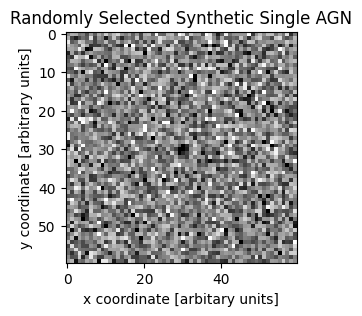

1


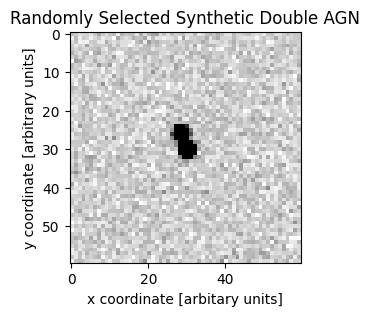

1


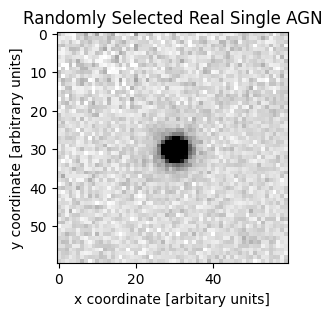

1


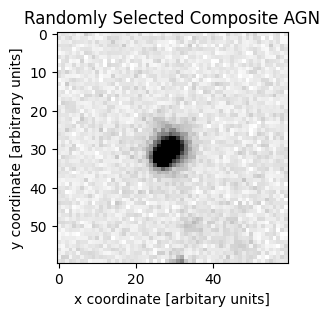

In [11]:
# Synthetic images
print(np.shape(val_dataset_modelB_sim))
print(np.shape(val_labels_modelB_sim))
#print(val_labels_modelB_sim[345])
print(np.where((val_labels_modelB_sim == 'single AGN'))[0])
print(np.where((val_labels_modelB_real == 'single AGN'))[0])
plot_dataset_sample(val_dataset_modelB_sim, val_labels_modelB_sim, 
                    title = "Randomly Selected Synthetic Single AGN", AGN_type = "single AGN")
plot_dataset_sample(val_dataset_modelB_sim, val_labels_modelB_sim, 
                    title = "Randomly Selected Synthetic Double AGN", AGN_type = "double AGN")

# Real images
plot_dataset_sample(val_dataset_modelB_real, val_labels_modelB_real, 
                    title = "Randomly Selected Real Single AGN", AGN_type = "single AGN")
plot_dataset_sample(val_dataset_modelB_real, val_labels_modelB_real, 
                    title = "Randomly Selected Composite AGN", AGN_type = "double AGN")






### Architecture and Design of *DualFinder*
*DualFinder* is a deep convolutional neural network with four convolutional layers, three fully connected layers, and an output layers with two neurons representing the two possible classes for our binary classification task: **single AGN** and **dual AGN**. 

#### `Conv2D` and `MaxPooling2d` Layers.
Following the structures of the AlexNET (Krizhevsky *et al* 2012), VGG6 (Simonyan & Zisserman 2014), and GaMorNet (Ghosh *et al* 2020), we begin our model with an input layer of filter size $96$. The filter in a convolutional layer is a matrix of weights that are applied iteratively to elemenents in the inputted image as the network "strides" over the two-dimensional grayscale image. Our CNN multiplies the weights in this filter to the imput values of each element in the image that is contained within our filter, sums up the result, outputs it to a single pixel in the next layer, and repeats this process over the entire image in several steps, or **strides**. The size of the stride indicates how many pixels the filter is moved before it is applied again. Consequently, the stride size informs the amount of downsampling the model performs form layer to layer. A larger stride size will lead to more downsampling. CNNs of similar architectures to *DualFinder* are designed to reduce the dimensionality of the inputted images to capture the pixels that produce maximum values when multiplied by the weights in our filter, which is often indicates that the model has captured the most important information in the image. In practice, the model accomplishes this downsampling through the use of a `MaxPooling2D` layer, which sums up the values in the filter and outputs them to the next layer. We repeat this process for three additional `Conv2D` layers past our input, with the filter size increasing in each layer to help the model capture finer details in the image. The larger the filter size, the larger the weight matrix and therefore more pixels "make the cut" from downsampling into the next round, and thus more small-scale structure is preserved. We intenionally set our initial filter size to be relatively small because we want the model to discover large scale repeated structure first before it learns from finer details in each image. This is done to prevent the model from recognizing background noise, contaminant sources, or fluctuations in the seeing of a given image as essential for classification, and to encourage the model to identify patterns – such as the presence of one (or two!) bright circular objects near the centers of each image. Our last convolutional layer has a filter size of $384$, which was empirically tested yield high-valued metrics in GaMorNet (Ghosh *et al*. 2020). We include a `for` loop that adds a given number `num_layers` of layers of this size. We fine-tune `num_layers` as a hyperparameter to measure its effect on the model's success. Once the data has been downsized through these layers, we flatten the layer and allow all neurons to be fully connected to those in the previous layer through the use of a `Dense` class fully connected layer. This allows the model to retail the *most important*, or high level, information from the image and pass it to the final output layer, with two output neurons representing the "single AGN" and "double AGN" classes for prediction. 

### Activation Functions
In a CNN, the value a neuron takes on is multiplied by a matrix of weights $w_i$, the result of which is added to a bias term $b_i$ and passed through a function to give an output to the neuron, which in a fully connected layer is sent to every neuron in the next layer, and in a convolutional layer is summed with other outputs within the filter and subsequently given to the following layer. Mathematically, this process is modeled by $$y_i(x) = \sum^{N}_{i = 1}f(w_i \cdot x_i + b_i)$$
where $N$ is the total number of neurons in each layer. The function $f$ is our *activation function* and it is essential for regulating neuron outputs to the next layer. Although the equation above is a linear transformation, these functions – along with the weight matricies – introduce non-linearity into the model essential for the model to make novel predictions and learn from the dataset. There are several activation functions available in the `Tensorflow` library which have their benefits and drawbacks for different machine learning tasks and purposes. We use the `leaky_relu` function, an adaptation of the popular ReLU (Rectified Liner Unit) function. In the ReLU function, neurons with negative values are set to zero, and neurons with positive values preserve their outputs and are passed onto the next layer. This model gained popularity over the earlier *sigmoid* function, which maps the output of a neuron to $0$ for large negative outputs or $1$ for large positive outputs, because of its simplicity (as it is a piecewise linear function), its computational efficiency, and its ability to preserve useful information from the neuron by outputing its value without correction to the next layer. Nevertheless,  models using ReLU often suffer from the "dying ReLU" problem, wherby setting the output of a neuron with a negative value has rendered it dormant and therefore does not take part in the rest of the training process. This leads to loss of information and instability while training the model. There have been several activation functions developed to combat this problem, including the `leaky_relu` function, which allows for small negative outputs to be passed onto the next layer. Some of the most popular activation functions and there graphs are plotted below. ![Activation Functions](markdown_images/activation_functions.png) (Image credit: Jadon Shruti (2018)., "Introduction to Different Activation Functions for Deep Learning"., *Medium*., https://medium.com/@shrutijadon/survey-on-activation-functions-for-deep-learning-9689331ba092)

Our final output layer uses the `softmax` activivation function, which is well-suited for categorical probability predictions because all of the component predictions that are created by the function must sum to 1 (there is a 100% probability that the model will predict *something*). We are treating our binary classification problem as a multi-class classification scheme with only two classes. We could've also represented our task as purely binary – in which case, we would have one output layer where the value of the neuron represents the probability that the image belongs to the positive class ($0$ represents no chance, and therefore the negative class). Both methods are equally valid ways of desiging the model, however, we intend to adjust our model architecture to account for three or more classes of images in future development, so using a categorical classification scheme allows us to more easily scale up the number of classes predicted by the model.

### `Dropout`, `Regularization`, and `BatchNormalization`.
*DualFinder* also contains several non-trainable layers that are dispersed between the `Conv2D`, `MaxPooling2D` and `Dense` layers within the model. Together, the `Dropout`, `Regularization` and `BatchNormalization` layers are designed to prevent the model from *overfitting* to the dataset. If a CNN is too deep of a network, it can achieve very high metrics when training on training data, but when tested on validation data, the model demonstrates poor performance. This is the "overfitting" problem, and it arises in very deep models where because of its complexity and learning capacity the model essentially "memorizes" the structure of the training data, down to its finest details, but doesnt learn the overall patterns well. So when presented with new data, it cannot recognize any patterns that are indicative of a class and therefore does not perform well. Because of the size of our model, overfitting remains an important problem with the model to monitor and fight against during training and testing, so lets go over the tools in our arsenal that help us prevent it.

`Dropout`: The technique of dropout involves randomly selecting a certain percentage of neurons and setting them to be untrainable (therefore "dropping them out") during training. This introduces uncertainty in the model and purposeful loss of information, which enables the model to learn the larger-scale patterns of an image more effectively and therefore apply them to new data. 

`Regularization`: L2 regularization involves applying a "penalty term" to the loss function that is the sum of the squares of the weights of the model. As such, the new loss function, with L2 regularization, is given by, 
$$ L = L_0 + \lambda \sum_{j = 1}^{N}(w_j)$$ 
where $L_0$ is the original loss function (in our case, categorical crossentropy) and $\lambda$ represents how much importance regularization has in the calculation of the loss function. $\lambda$ is an adjustable hyperparameter that is fine-tuned with training runs. While the loss function is minimized during training, the introduction of L2 regularization tends to decay the weights to near zero (but crucially non-zero) values. This allows the weights to be dominated by outputs from features of the image, and less affected by background noise, which leads to better applicability of the model to new data and therefore less overfitting.

`BatchNormalization`: Batch normalization serves many purposes in regulating model training, from stabilizing gradient descent to reducing CNN training times by fascilitating faster loss function convergence, and generally is a method that improves the stability and versatility of the model. It does so by slightly adjusting the activation function of a given layer such that the mean output of the function is $0$ and its standard deviation is $1$ over a given image batch. This process introduces a small amount of noise via random variations caused by the normalization to the model outputs, which in turn helps prevent the model from memorizing the noise profiles of the dataset. 

Putting it all together, we show a schematic diagram of *DualFinder* below, which highlights some of the key components (such as the convolutional layers, dropout layers, and fully connected layers) of the model's architecture. ![DualFinder Diagram](markdown_images/structure_of_dual_finder.png)

All of these components of the model work together, often in ways unknown to us as the user due to the highly non-linear structure of the network, to extract features from the dataset and learn how they correlate to the given labels, so that once fully trained, the model can effectively discover similar images based on the presence (or lack thereof) of these features in new images. 

### Compiling *DualFinder*
Once we have preprocessed our data, we are ready to compile and train our model. Our model contained over 9 million trainable parameters, and countless connections between neurons that makes the calculations of weights and biases a highly non-linear problem. As such, we cannot rely on familiar algorithms such as $\chi^2$ minimization or even Markov Chain Monte Carlo (MCMC) simulations to arrive at optimial weights and biases for our dataset. 

Enter *Stochastic Gradient Descent* (SGD). SGD projects our optimizable parameters into a high-dimensional parameter space according to the outputs of the binary cross-entropy loss function. This space is a complicated surface with many peaks and valleys that is difficult to visualize, as for most machine-learning applications, usually has a higher dimension than the three we can easily visualize. Nevertheless, algorithms employing SGD are specially designed to handle this multidimensionality. It calculates the gradient at a particular point, corresponding to a combination of weight and bias values, and adjusts these weights so as to "travel" along the gradient (which we know from multivariable calculus represents the path of greatest ascent/descent" towards the **global minimum** of the loss function parameter space. For our model, we use a modern version of SGD called `Adam`, which is an adaptive SGD algorithm that continually calculates the *momentum* of the gradient descent. In this algorithm, the next step in gradient descent is calculated by taking the update to the gradient at each iteration and takes the linear combination of this update, and the previous, to create an update to the gradient descent. This method allows for more efficient convergence towards a local minimum, though there have been studies that cast doubt on the completeness of this conversion for large-parameter models. Nevertheless, it remains popular among modern machine learning models for its efficiency and relative efficacy, and is what we used to optimize our model.

#### Hyperparameters: `learning_rate`
The algorithm does this in sufficiently small incremental steps, often called a "learning rate" in machine learning, so that it is efficiently progressing towards a minimum without overstepping what could be a valley in the parameter surface. This learning rate is often an adjustable *hyperparameter* of the model – an input to our model that can be adjusted manually to test its effect on the model's efficacy – that needs to be optimized for the SGD algorithm to converge on a minimum. If the learning rate is too large, then the optimization algorithm can completely skip over minima and fail to converge. If the learning rate is too small, the time to convergence could be enormous, and we may lack the computing resources to fasciliate convergence this way. As such, finding the optimal learning rate is crucial to model success.

#### Hyperparameters: `batch_size`
It might initially seem wise to train our model on one image at a time to ensure the model has ample time to learn from its features. However, for large models with large datasets, this approach can be impractical, as the computational resources required for this may not be available. Moreover, this may lead to the optimizer getting stuck in local minima and not learning from overall patterns in the entire dataset. As good as GPUs are at parallelization, training on the entire dataset all at once is also not feasible for most (if not all) GPU resources, and will most-likely cause your program to crash. This is where *mini batching* will be useful. Mini-batching, or simply batching, creates clusters of images within the training data based on a `batch_size` (how many images are contained within the batch). The model will be trained on the images within a batch simultaneously, allowing the model to capture overall structure present in many (or all)images without sacrificing its ability to detect individual variations. This is also an adjustable hyperparameter. Larger datasets may require a larger batch size to ensure efficient convergence, while smaller datasets most likely use smaller batch sizes to ensure variation in the dataset isn't missed. Batch sizes are usually given in powers of 2, which empirically is seen to yield better optimizer convergence. It is important to note that adjusting the batch size hyperparameter may also necessitate a corresponding adjustment to the learning rate, as a larger batch size will need a smaller learning rate to make sure that the model does not overshoot minima.

#### Hyperparameters: `dropout`
Neural networks with large numbers of parameters, when trained over many training epochs, can get very good at identifying training data correctly. So much so, that the model essentially memorizes the dataset, but doesnt learn from the features and is thus unable to reproduce its success with brand-new data. This phenomena is called *overfitting* and it often manifests itself in a model achieving near perfect accuracy on training datasets, but failing to reach benchmarks on validation or testing datasets. We implement several methods to combat this, but one of the most popular and effective is to randomly set the outputs of a certain percentage of neurons to zero. This "deactivates" them, and removes them as trainable parameters during a given training cycle. This ensures that some neurons are learning from features for the first time in any given training iteration, which helps avoid overfitting. The percentage of neurons that are randomly selected for deactivation, `dropout`, is an adjustable hyperparameter that has significant impact on training efficacy. If too little neurons are dropped out, then the model is prone to overfitting. If too many are dropped out, then the model cannot effectively learn from the dataset.

### Training *DualFinder*
Lets illustrate how to construct a training run of *DualFinder*. We first must create an instance of our `DualFinder` class, which contains several functions that train the model and monitor its progress. As of the creation of this project, our classification problem is binary, so we have two possible classes that a given image can fall under: "single AGN" or "double AGN". 

Our loss function is the *categorical crossentropy* function, given by, $$ L = -\frac{1}{N}\sum_{i}^{N}y_i\log{p(y_i)}+(1-y_i)\log{(1-p(y_i))} $$

where $y_i$ is the true value of the class, $\log{p(y_i)}$ represents the model's prediction, and $N$ is the total number of datapoints. Both the predicted and true labels $\log{p(y_i)}$ and $y_i$ respectively must be numerically encoded so that the loss function can be calculated and thus prediction can be made. For binary classification tasks, it is common to define a *positive* and *negative* class and represent the output of the model as its prediction of the likelihood that a given image belongs to the positive class. In *DualFinder*, we define the positive class to be if two point sources are detected in the image. Consequently, the label of "double AGN" is given a value of `1.0` and an image labeled as a "single AGN" is given a value of `0.0` (lack of a double AGN). The final two neurons of the model output these probabilities, the loss function check's the model's probability prediction to the true value, and outputs a value, which motivates the continued exploration of parameter space towards the global minimum. 

One approach to numerically encode labels is to create a "binary class matrix" from categorical class vectors. In this method, the categorical variable, in our case the label "single AGN" or "double AGN", is first mapped to a numerical value, in our case "single AGN" to $0$ and "double AGN" $1$. Then, the array (vector) containing the numerical encoding of these labels are passed into a function that creates a matrix of ones and zeros that represent the presence of a particular class in a particular label. To illustrate this, suppose that we encoded a snipet of our training labels such that $$y_i = [..., 1, 1, 0, 0, 1....]$$. The binary matrix representation of this would be $$[...,
[0, 1], 
[0, 1], 
[1, 0],
[1, 0], 
[0, 1], ...]$$. 
We create these matricies using Tensorflow's built-in `tensorflow.keras.utils.to_categorical()` function. Once our labels are encoded, we compile our model with the binary cross-entropy loss function and all useful monitoring metrics – which in our case includes accuracy, false positives, false negatives, true positives, true negatives, recall, precision, F1 score, and the Matthews Correlation Coefficient (MCC).
#### Model Metrics
**Recall**: Recall measures how often the model correctly predicts the positive class out of the total number of positives in the dataset. A recall value of 1 indicates the model always predicts the positive class correcly, i.e, any time there is an instance of the positive class in the dataset, the model identifies it correctly. Because the goal of our model is to detect as many dual AGN candidates (positive classes) as available in a dataset, achieving a high recall is top priority and as such this metric is arguably the most important for evaluating the success of *DualFinder*.

**Precision**: Precision is a measure of how many positive predictions made by the model were correct. It is defined as the predicted positives divided by the total number of positives $\frac{TP}{TP+FP}$ where $TP$ is a true positive and $FP$ is a false positive. 

The distinction between precision and recall is subtle. Essentially, recall measures the percentage of positive class detections that were identified correctly, while precision measures how often the model is correct when it predicts a positive detection. Both are vital to measuring the efficacy of *DualFinder* though a high value in one or the other individually doesn't necessarily mean that the model is performing well. For example, suppose during a given training iteration the model achieves a high precion of $P = 98.7\%$ while the recall lags behind at $R = 50.7\%$. This would mean that when the model predicts a positive class, it is highly likely to be correct. However, because the recall is so low, the model rarely predicts a positive class, and so it misses a lot of potential detections (i.e, the model has many false negatives). A *DualFinder* model with these metrics would be horrible at detecting dual AGN candidates, as it would miss-classify most of them as single AGN. Given the size of the datasets we hope to implement *DualFinder* on, it is highly unlikely that scientists would review images classified as single AGN, so the model would not be able to perform its duties and actually hampers further investigation of the images that it misses.

On the other hand, if the recall is high but the precision is low, then the model classifies nearly everything as a potential dual AGN candidate, which is not very useful. Consequently, a model is optimally trained when both metrics take on high values.

**F1 Score**: F1 score is defined as $$\frac{precision \cdot recall}{precision + recall}$$ and is thus a combination of the two metrics above. It is an effective single metric to use to evaluate the success of a model without running into the issues of using solely precision or recall outlined above. As is the case with the metrics above, a high value of the F1 score indicates high values in precision *and* recall and thus a potentially well-trained model. 

**MCC**: The Matthews Correlation Coefficient (MCC) measures the difference between the actual and predicted values of the dataset's labels and outputs a number that is equivalent to the $\chi^2$ value of a $2 \times 2$ correlation matrix. Unlike the metrics above, which are restricted to values between $0$ and $1$, the MCC can take on values in the range $(-1, 1)$, where $-1$ represents an inverse prediction (the model predicts the exact opposite class than its true value), $0$ represents a random prediction, and $1$ represents perfect correlation between predictions and true class values. 

### Training Proceedure
Once our model is compiled, we are ready to begin training. Models of `tf.keras.Model` class have a built-in function called `model.fit()` that handles training execution. It has the following positional and optional inputs: 
```python
model.fit( 
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1)
```
Evidently, this function is very versitile and can handle a wide range of data structures. In our training procedure, we will mainly use the `x, y, batch_size, epochs, verbose, callbacks, validation_data, shuffle, class_weight` parameters. Let's go through each one and its importance towards model training.

`x`: This is our training data. This function accomodates several data structures, namely tensorflow `Tensor` and `Dataset` objects, as well as `numpy` arrays. We will be using the numpy arrays generated above for our training. 

`y`: These are the labels associated with our training data. They must be encoded before being passed into the function. Because our model has two output neurons instead of the typical one for a binary classification scheme, the labels must be encoded as if the model was tasked with a multi-class classification scheme with two classes. As such, our model is not constructed for one hot encoding, so we must use the encoding algorithm outlined above. [REVISE THIS]

`batch_size`: Our batch size – how many images the model will be trained on simultaneously. Accepts `int` objects.

`epochs`: The number of iterations through the entire training dataset. Accepts `int` objects. 

`verbose`: Determines what the function outputs to the system to monitor training progress. A value of `0` means that the function outputs nothing to the console, and the user does not know at what stage of training the model is. `1` outputs all available information about training progress to the user. `2` outputs some useful information, but excludes the progress bar present in `1.`

`callbacks`: This input accepts a list of Tensorflow keras `Callback` objects, which are constructed to monitor certain aspects of the model's training and make changes to the training procedure while it is in motion. These objects allow us to make these changes, or monitor progress, without restarting the training run. There are dozens of pre-fabricated callbacks available in the Tensorflow API, and its possible to make custom ones. For training `DualFinder` we make use of the `ModelCheckpoint`, `EarlyStopping`, and our custom `FeatureMapCallback`. The `ModelCheckpoint` callback saves the model and its weights as a `.keras` file after each training epoch so that if training is interrupted, the user can begin training the model from the last checkpoint instead of the restarting. The `EarlyStopping` checkpoint monitors the progression of an evalution metric over a specified number of epochs (in our case, 5). If the metric is measured to decrease for longer than a specified tolerance level, training is stopped and the model is saved. This technique of "early stopping" is utilized in machine learning to train unstable models that might incur massive fluctuations in their evaluation metrics over the course of their training. Our custom `FeatureMapCallback` takes as input a randomly-selected image from the dataset (either a single or a dual), has the model predict the class of the image throughout training, and plots and saves a heatmap of the features of the image the model used to classify it, and therefore what the model deemed as "important indicators" of the class of the object. These plots allow us to determine what features the model is picking up on across its hidden layers and over all of its training epochs, revealing information about the model's decision-making that is otherwise hidden in the hidden layers. 

`validation_data`: Accepts a tuple containing our validation dataset (stored in a numpy array) and our encoded validation labels (also stored in a numpy array). Data is passed into the function in this way because the function allows the user to pass their entire dataset into `x` and let the model automatically separate the training data from the validation data using `validation_split`. 

`class_weight`: Accepts as input a dictionary of weights (floats) that map to the (integer) classes of the dataset. Many datasets (including our own) are imbalanced, and it is often unfeasible to have equal number of samples per class in real data. As such, we want to train our model such that it can make accurate predictions when faced with an imbalanced dataset. Our `class_weights` dictionary weights under-represented classes such that predicting these classes has more of an impact on the loss function so that these classes do not get ignored during training. As such, using class weights during training is a powerful tool to prevent overfitting. We create our `class_weigts` dictionary using the `sklearn.utils.class_weight.compute_class_weight` function from Scikit-Learn – a python library with many additional machine learning algorithms and tools. 

We demonstrate an example training run using our **model A** training scheme. In this program, we train our model on synthetic and real data for 30 training epochs. In our first iteration, we want to illustrate how poorly chosen hyperparameters can negatively impact training success. Since our model is trained on both types of data, we would want to use a smaller learning rate so that the model doesn't miss important features. We will also want to use a medium to large batch size because we want to include as many different samples from each data type for the model to learn from. As such, we will chose a large learning rate of `1e-3` and a large batch size of `128`. We run the training algorithm and display plots of metrics vs. epoch below. 

In [14]:
#Specify some initial hyperparameters to illustrate their impact on training. 
epochs = 30
batch_size = 128
learning_rate = 1e-3
image_shape = (60, 60, 1)
num_layers = 1
model_type = "modelB"
dropout_rate = 0.5
model_filepath = "saved_models/"

dual_finder_instance = DualFinder(train_dataset_modelA, val_dataset_modelA, image_shape, train_labels_modelA, val_labels_modelA, epochs, batch_size, learning_rate, num_layers, model_type)
history_bad_params_modelA, model = dual_finder_instance.trainCNN(model_filepath = model_filepath, dropout_rate = dropout_rate)

['double AGN' 'single AGN' 'single AGN' ... 'single AGN' 'double AGN'
 'double AGN']
['double AGN' 'double AGN' 'double AGN' ... 'double AGN' 'single AGN'
 'single AGN']
Converting to list
Converting to list


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 60, 60, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 96)     │        13,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 30, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 30, 30, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,720,674 (37.08 MB)

 Trainable params: 9,718,434 (37.07 MB)

 Non-trainable params: 2,240 (8.75 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 60, 60, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 96)     │        13,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 30, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 30, 30, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,720,674 (37.08 MB)

 Trainable params: 9,718,434 (37.07 MB)

 Non-trainable params: 2,240 (8.75 KB)

2024-04-19 00:37:22,454 - INFO - save_feature_maps == True, WILL save feature maps


Feature map will feature: ['double AGN']
Shape of randomly selected image: (1, 60, 60, 1)
Epoch 1/30


KeyboardInterrupt: 

In [15]:
history_bad_params = load_training_history("saved_models/saved_history.npy")

acc_bad_paramsA = history_bad_params['binary_accuracy']
loss_bad_paramsA = history_bad_params['loss']
val_loss_bad_paramsA = history_bad_params['val_loss']
val_acc_bad_paramsA = history_bad_params['val_binary_accuracy']

recall_bad_paramsA = history_bad_params['recall']
val_recall_bad_paramsA = history_bad_params['val_recall']
precision_bad_paramsA = history_bad_params['precision']
val_precision_bad_paramsA = history_bad_params['val_precision']

f1_score_bad_paramsA = history_bad_params['f1_score']
val_f1_score_bad_paramsA = history_bad_params['val_f1_score']
#mcc_bad_paramsA = history_bad_params['MCC']
#val_mcc_bad_paramsA = history_bad_params['val_MCC']

save_filepath = "dual_finder/dual_finder/cnn/saved_figures/"
modelA_epochs = np.arange(0, 30)

fig, ax = plot_training_progress(loss_bad_paramsA, acc_bad_paramsA, modelA_epochs, save_filepath = save_filepath, training_run = "Bad Parameters",
                                 recall = recall_bad_paramsA, precision = precision_bad_paramsA, f1_score = f1_score_bad_paramsA,
                                 val_loss = val_loss_bad_paramsA, val_acc = val_acc_bad_paramsA, val_recall = val_recall_bad_paramsA, val_precision = val_precision_bad_paramsA, 
                                 val_f1_score = val_f1_score_bad_paramsA)

                                 

AssertionError: File must have the .npy extension

### Training Run One Discussion
With our choice of hyperparameters above, we see that the model's training accuracy, precision, recall, and F1 score seems to plateu at a value of $0.70$, while the validation values of these metrics fluctuate wildly between values of ~$0.5$ and ~ $0.70$ over the training run. This is likely caused by our high learning rate, as the optimizer takes large steps between local maxima and minima in loss function space, corresponding to low and high values for these metrics respectively. As such, our optmizer has not converged on a stable solution, and has likely not learned the features of the dataset well enough to produce consistent results, which is not suitable for a detection prorgam. This demonstrate the essentialness of choosing optimal hyperparameter values when training a model. 


### Training Run Two: Revised Hyperparameters

Let's redo this training procedure with better informed choices for hyperparameters. We see that our learning rate was too high, so lets reduce it to `learning_rate = 5e-7`. Additionally, lets reduce our batch size to `batch_size = 32` to make sure that our model does not miss small but important variations in the features of the dataset. While this will increase our training time, it may provide some stability to the model. Training for the same number of epochs, `epochs = 30` as above, we train a fresh instance of our model using these hyperparameters and plot the results below.

In [ ]:
epochs = 30
revised_batch_size = 64
revised_learning_rate = 5e-7
image_shape = (60, 60, 1)
num_layers = 1
dropout_rate = 0.5
model_type = "modelB"
model_filepath = "saved_models_better_params/"

dual_finder_instance = DualFinder(train_dataset_modelA, val_dataset_modelA, image_shape, train_labels_modelA, val_labels_modelA, epochs, revised_batch_size, revised_learning_rate, num_layers, model_type)
history_bad_params_modelA, model = dual_finder_instance.trainCNN(dropout_rate = dropout_rate, model_filepath = model_filepath)

### Training Run Two Results: Revised Hyperparameters

In [ ]:
history_better_params = load_training_history("saved_models_better_params/saved_history.npy")

acc_better_paramsA = history_better_params['binary_accuracy']
loss_better_paramsA = history_better_params['loss']
val_loss_better_paramsA = history_better_params['val_loss']
val_acc_better_paramsA = history_better_params['val_binary_accuracy']

recall_better_paramsA = history_better_params['recall']
val_recall_better_paramsA = history_better_params['val_recall']
precision_better_paramsA = history_better_params['precision']
val_precision_better_paramsA = history_better_params['val_precision']

f1_score_better_paramsA = history_better_params['f1_score']
val_f1_score_better_paramsA = history_better_params['val_f1_score']

save_filepath_better_params = "dual_finder/dual_finder/cnn/saved_figures_better_params_modelA/"
modelA_epochs = np.arange(0, 30)

fig, ax = plot_training_progress(loss_better_paramsA, acc_better_paramsA, modelA_epochs, save_filepath = save_filepath_better_params, training_run = "Better Parameters",
                                 recall = recall_better_paramsA, precision = precision_better_paramsA, f1_score = f1_score_better_paramsA,
                                 val_loss = val_loss_better_paramsA, val_acc = val_acc_better_paramsA, val_recall = val_recall_better_paramsA, val_precision = val_precision_better_paramsA, 
                                 val_f1_score = val_f1_score_better_paramsA)

## Transfer Learning 

When we revised our hyperparameters to better reflect our model architecture and the structure of our dataset, we were able to train a more stable model that achieved a validation accuracy, recall, precision, and F1 score of approximately $45\%$. This is statistically less than if we were randomly deciding whether an image was a single or a dual. Since the training metrics were high, the model is most-likely overfitting to the data. We can help remedy this by including more dropout/regularization layers, fine-tuning hyperparameters, and/or adjusting our training procedure. We can try to achieve this through rigorous hyperparameter optimization. We can test many hyperparameter combinations, revising their values based on training results, until we arrive at a combination that yields an optimally trained model given our architecture and dataset structure. We can systematically test these hyperparameters through the use of an optimization algorithm, such as a Tree-Based Parzen Estimator (TPE) (which we will discuss in detail on the "Optimization" section of this tutorial). However, these methods require several training runs to converge on an optimal solution. While we will eventually utilize them for hyperparameter optimization the nature of our dataset, with its synthetic and real data components, lends itself nicely to a machine-learning training tactic called *transfer learning*. 

Transfer learning refers to the process of retraining a model, that has been pretrained on a certain dataset, with another dataset while preserving the information learned from its original training input. This process allows the model to retain important feature information it learned from the original training dataset while learning new – and most likely specialized – information from the new dataset, thus producing a better informed and hopefully more accurate model. We call our transfer-learning scheme the **model B** training procedure, and we initiate it by training the model freely on our synthetic dataset for 10 training epochs. Once this finishes, we "freeze" several convolutional layers by setting their parameters to "untrainable", preserving the data learned from the synthetic set, and training the model on our real dataset for 10 training epochs. We then gradually unfreeze the layers by resetting them to "trainable", allowing the neurons in these layers to adjust their weights and biases based on real data. We unfreeze one layer per training epoch. Once completely unfrozen, we allow the model to train freely on the real dataset for however many epochs remain after the unfreezing stage, as we allow the model to be trained in the transfer-learning stage for 20 total epochs. Theoretically, this method will allow the model to learn the noise and light profiles of real HSC data without overwriting the valuable overall structure it learned from the synthetic datam thus yielding a highly accurate model. For our data, where an ideally-trained model would learn overall structure (such as where two point sources may broadly be located in a given image if they are present) from the synethic images, then learn fine structure and appropiate noise levels from the real images during the transfer learning stage. As such, we expect this method to yield a significantly more accurate model than training the model on all image types simultaneously, as mixing real and synthetic data in the **model A** procedure does not allow the model sufficient time to learn from the structures in one datatype before it must learn from the other, which contributes to instability in the model and lower metrics overall.

We demonstrate this training proceedure below, using hyperparameters that were optimized during the research and development of this algorithm over this past summer. As with **model A**, we plot the results of this training procedure below.

In [ ]:
init_epochs = 10
batch_size = 32
learning_rate =  5.518358e-07
#learning_rate = 1.72332548599593680e-06
image_shape = (60, 60, 1)
num_layers = 1
model_type = "modelB"
model_filepath = "saved_models_example_modelB/"
#num_frozen_layers = 22
num_frozen_layers = 17
num_frozen_fc_layers = 0

dual_finder_instance = DualFinder(train_dataset_modelB_sim, val_dataset_modelB_sim, image_shape, train_labels_modelB_sim, val_labels_modelB_sim, init_epochs, batch_size, learning_rate, num_layers, model_type)
#history_synthetic, pretrained_model = dual_finder_instance.trainCNN(model_filepath)
#0.32523228915885216


In [ ]:
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
tl_epochs = 30
#tl_learning_rate = 2.7607071462012844e-08
tl_learning_rate = 1.72332548599593680e-06
# num_frozen_layers = 12
tl_batch_size = 32
#tl_learning_rate = 8.944489782605628e-06
#tl_learning_rate = 5.518358e-07
dropout_percentage = 0.21253947483790814
history_synth, history_frozen, history_unfreeze, history_unfrozen, model_retrained = dual_finder_instance.transferLearning(num_frozen_layers, model_filepath, tl_epochs, train_dataset_modelB_real, train_labels_modelB_real, val_dataset_modelB_real, val_labels_modelB_real, tl_batch_size, tl_learning_rate, dropout_percentage, save_feature_maps = True)

### Training Results: Transfer Learning

In [ ]:
history_synthetic = load_training_history("saved_models_example_modelB/saved_history.npy")
acc_synth = history_synthetic['binary_accuracy']
loss_synth = history_synthetic['loss']
val_loss_synth= history_synthetic['val_loss']
val_acc_synth = history_synthetic['val_binary_accuracy']

recall_synth = history_synthetic['recall']
val_recall_synth = history_synthetic['val_recall']
precision_synth = history_synthetic['precision']
val_precision_synth = history_synthetic['val_precision']

f1_score_synth = history_synthetic['f1_score']
val_f1_score_synth= history_synthetic['val_f1_score']
#mcc_better_synth= history_synthetic['MCC']
#val_mcc_synth = history_synthetic['val_MCC']


save_filepath_synth = "dual_finder/dual_finder/cnn/saved_figs_modelB/saved_figures_synth_modelB/"
modelB_synth_epochs = np.arange(0, 10)

fig, ax = plot_training_progress(loss_synth, acc_synth, modelB_synth_epochs, save_filepath = save_filepath_synth, training_run = "Train on Synthetic Dataset",
                                 recall = recall_synth, precision = precision_synth, f1_score = f1_score_synth,
                                 val_loss = val_loss_synth, val_acc = val_acc_synth, val_recall = val_recall_synth, val_precision = val_precision_synth, 
                                 val_f1_score = val_f1_score_synth)

history_frozen = load_training_history("saved_models_example_modelB/saved_history_frozen.npy")
#print(history_frozen)
acc_frozen = history_frozen['binary_accuracy']
loss_frozen = history_frozen['loss']
val_loss_frozen = history_frozen['val_loss']
val_acc_frozen = history_frozen['val_binary_accuracy']

recall_frozen = history_frozen['recall']
val_recall_frozen = history_frozen['val_recall']
precision_frozen = history_frozen['precision']
val_precision_frozen = history_frozen['val_precision']

f1_score_frozen = history_frozen['f1_score']
val_f1_score_frozen= history_frozen['val_f1_score']

save_filepath_frozen = "dual_finder/dual_finder/cnn/saved_figs_modelB/saved_figures_frozen_modelB/"
modelB_frozen_epochs = np.arange(10, 20)

fig, ax = plot_training_progress(loss_frozen, acc_frozen, modelB_frozen_epochs, save_filepath = save_filepath_frozen, training_run = "Layers Frozen",
                                 recall = recall_frozen, precision = precision_frozen, f1_score = f1_score_frozen,
                                 val_loss = val_loss_frozen, val_acc = val_acc_frozen, val_recall = val_recall_frozen, val_precision = val_precision_frozen, 
                                 val_f1_score = val_f1_score_frozen)

# During the unfreezing stage, we train the model for one training epoch per newly-unfrozen layer, so the training history object is only recorded
# for one epoch. As such we load all of the training epochs for the unfreeze portion of the training procedure into an array to be plotted using
# our plotting functionality.

histories_unfreeze = []
for ii in np.arange(1, num_frozen_layers):
    history = load_training_history(f"saved_models_example_modelB/saved_history_unfreeze_{ii}.npy")
    histories_unfreeze.append(history)
    
acc_values_unfreeze = []
loss_values_unfreeze = []
recall_values_unfreeze = []
precision_values_unfreeze = []
f1_values_unfreeze = []
mcc_values_unfreeze = []

val_acc_values_unfreeze = []
val_loss_values_unfreeze = []
val_recall_values_unfreeze = []
val_precision_values_unfreeze = []
val_f1_values_unfreeze = []
val_mcc_values_unfreeze = []


for history in histories_unfreeze:
    acc_values_unfreeze.append(history['binary_accuracy'][0])
    loss_values_unfreeze.append(history['loss'][0])
    recall_values_unfreeze.append(history['recall'][0])
    precision_values_unfreeze.append(history['precision'][0])
    f1_values_unfreeze.append(history['f1_score'][0])
    #mcc_values_unfreeze.append(history['static_MCC'])

    val_acc_values_unfreeze.append(history['val_binary_accuracy'][0])
    val_loss_values_unfreeze.append(history['val_loss'][0])
    val_recall_values_unfreeze.append(history['val_recall'][0])
    val_precision_values_unfreeze.append(history['val_precision'][0])
    val_f1_values_unfreeze.append(history['val_f1_score'][0])
    #val_mcc_values_unfreeze.append(history['val_static_MCC'])

print(np.shape(loss_values_unfreeze))
save_filepath_unfreeze = "dual_finder/dual_finder/cnn/saved_figs_modelB/saved_figures_unfreeze_modelB/"
unfreeze_end = 11+(num_frozen_layers-1) # initial frozen training plus however long it takes to unfreeze the layers. 
modelB_unfreeze_epochs = np.arange(11, 11+(num_frozen_layers-1))

fig, ax = plot_training_progress(loss_values_unfreeze, acc_values_unfreeze, modelB_unfreeze_epochs, save_filepath = save_filepath_unfreeze, training_run = "Gradual Unfreezing",
                                 recall = recall_values_unfreeze, precision = precision_values_unfreeze, f1_score = f1_values_unfreeze,
                                 val_loss = val_loss_values_unfreeze, val_acc = val_acc_values_unfreeze, val_recall = val_recall_values_unfreeze, val_precision = val_precision_values_unfreeze, 
                                 val_f1_score = val_f1_values_unfreeze)



history_unfrozen = load_training_history("saved_models_example_modelB/saved_history_unfrozen.npy")
acc_unfrozen = history_unfrozen['binary_accuracy']
val_acc_unfrozen = history_unfrozen['val_binary_accuracy']
loss_unfrozen = history_unfrozen['loss']
val_loss_unfrozen= history_unfrozen['val_loss']
#val_acc_synth = history_synthetic['val_binary_accuracy']

recall_unfrozen = history_unfrozen['recall']
val_recall_unfrozen = history_unfrozen['val_recall']
precision_unfrozen = history_unfrozen['precision']
val_precision_unfrozen = history_unfrozen['val_precision']

f1_score_unfrozen = history_unfrozen['f1_score']
val_f1_score_unfrozen= history_unfrozen['val_f1_score']
modelB_unfrozen_epochs = np.arange(unfreeze_end, unfreeze_end + len(acc_unfrozen))
save_filepath_unfrozen = "dual_finder/dual_finder/cnn/saved_figs_modelB/save_figures_unfrozen_modelB/"
fig, ax = plot_training_progress(loss_unfrozen, acc_unfrozen, modelB_unfrozen_epochs, save_filepath = save_filepath_unfrozen, training_run = "Fully Unfrozen",
                                 recall = recall_unfrozen, precision = precision_unfrozen, f1_score = f1_score_unfrozen,
                                 val_loss = val_loss_unfrozen, val_acc = val_acc_unfrozen, val_recall = val_recall_unfrozen, val_precision = val_precision_unfrozen, 
                                 val_f1_score = val_f1_score_unfrozen)


In [ ]:
# Alternative plotting version that plots all sections of the training run on the same plot, color coding them by 
# step in the transfer learning process
def extract_f1(f1_array):
    f1_score = [entry[1] for entry in f1_array]
    return f1_score
#Synthetic training phase
history_synthetic = load_training_history("saved_models_example_modelB/saved_history.npy")
acc_synth = history_synthetic['binary_accuracy']
loss_synth = history_synthetic['loss']
val_loss_synth= history_synthetic['val_loss']
val_acc_synth = history_synthetic['val_binary_accuracy']

recall_synth = history_synthetic['recall']
val_recall_synth = history_synthetic['val_recall']
precision_synth = history_synthetic['precision']
val_precision_synth = history_synthetic['val_precision']

f1_score_synth = extract_f1(history_synthetic['f1_score'])
val_f1_score_synth= extract_f1(history_synthetic['val_f1_score'])
modelB_synth_epochs = np.arange(0, 10)

# Frozen training phase
history_frozen = load_training_history("saved_models_example_modelB/saved_history_frozen.npy")
#print(history_frozen)
acc_frozen = history_frozen['binary_accuracy']
loss_frozen = history_frozen['loss']
val_loss_frozen = history_frozen['val_loss']
val_acc_frozen = history_frozen['val_binary_accuracy']

recall_frozen = history_frozen['recall']
val_recall_frozen = history_frozen['val_recall']
precision_frozen = history_frozen['precision']
val_precision_frozen = history_frozen['val_precision']

f1_score_frozen = extract_f1(history_frozen['f1_score'])
val_f1_score_frozen= extract_f1(history_frozen['val_f1_score'])
modelB_frozen_epochs = np.arange(10, 20)

#Unfreeze training phase
histories_unfreeze = []
for ii in np.arange(1, num_frozen_layers):
    history = load_training_history(f"saved_models_example_modelB/saved_history_unfreeze_{ii}.npy")
    histories_unfreeze.append(history)
    
acc_values_unfreeze = []
loss_values_unfreeze = []
recall_values_unfreeze = []
precision_values_unfreeze = []
f1_values_unfreeze = []


val_acc_values_unfreeze = []
val_loss_values_unfreeze = []
val_recall_values_unfreeze = []
val_precision_values_unfreeze = []
val_f1_values_unfreeze = []



for history in histories_unfreeze:
    acc_values_unfreeze.append(history['binary_accuracy'][0])
    loss_values_unfreeze.append(history['loss'][0])
    recall_values_unfreeze.append(history['recall'][0])
    precision_values_unfreeze.append(history['precision'][0])
    f1_values_unfreeze.append(extract_f1(history['f1_score'])[0])
    #mcc_values_unfreeze.append(history['static_MCC'])

    val_acc_values_unfreeze.append(history['val_binary_accuracy'][0])
    val_loss_values_unfreeze.append(history['val_loss'][0])
    val_recall_values_unfreeze.append(history['val_recall'][0])
    val_precision_values_unfreeze.append(history['val_precision'][0])
    val_f1_values_unfreeze.append(extract_f1(history['val_f1_score'])[0])
unfreeze_end = 20+(num_frozen_layers-1) # initial frozen training plus however long it takes to unfreeze the layers. 
modelB_unfreeze_epochs = np.arange(20, unfreeze_end)

history_unfrozen = load_training_history("saved_models_example_modelB/saved_history_unfrozen.npy")
acc_unfrozen = history_unfrozen['binary_accuracy']
val_acc_unfrozen = history_unfrozen['val_binary_accuracy']
loss_unfrozen = history_unfrozen['loss']
val_loss_unfrozen= history_unfrozen['val_loss']

recall_unfrozen = history_unfrozen['recall']
val_recall_unfrozen = history_unfrozen['val_recall']
precision_unfrozen = history_unfrozen['precision']
val_precision_unfrozen = history_unfrozen['val_precision']

f1_score_unfrozen = extract_f1(history_unfrozen['f1_score'])
val_f1_score_unfrozen= extract_f1(history_unfrozen['val_f1_score'])
modelB_unfrozen_epochs = np.arange(unfreeze_end, unfreeze_end + len(acc_unfrozen))

combined_data = [
    {
        'label': 'Synthetic',
        'Accuracy': {'Training': acc_synth, 'Validation': val_acc_synth},
        'Loss': {'Training': loss_synth, 'Validation': val_loss_synth},
        'Recall': {'Training': recall_synth, 'Validation': val_recall_synth},
        'Precision': {'Training': precision_synth, 'Validation': val_precision_synth},
        'F1 Score': {'Training': f1_score_synth, 'Validation': val_f1_score_synth},
    },
    {
        'label': 'Frozen',
        'Accuracy': {'Training': acc_frozen, 'Validation': val_acc_frozen},
        'Loss': {'Training': loss_frozen, 'Validation': val_loss_frozen},
        'Recall': {'Training': recall_frozen, 'Validation': val_recall_frozen},
        'Precision': {'Training': precision_frozen, 'Validation': val_precision_frozen},
        'F1 Score': {'Training': f1_score_frozen, 'Validation': val_f1_score_frozen},
    },
    {
        'label': 'Gradual Unfreezing',
        'Accuracy': {'Training': acc_values_unfreeze, 'Validation': val_acc_values_unfreeze},
        'Loss': {'Training': loss_values_unfreeze, 'Validation': val_loss_values_unfreeze},
        'Recall': {'Training': recall_values_unfreeze, 'Validation': val_recall_values_unfreeze},
        'Precision': {'Training': precision_values_unfreeze, 'Validation': val_precision_values_unfreeze},
        'F1 Score': {'Training': f1_values_unfreeze, 'Validation': val_f1_values_unfreeze},
    },
    {
        'label': 'Unfrozen',
        'Accuracy': {'Training': acc_unfrozen, 'Validation': val_acc_unfrozen},
        'Loss': {'Training': loss_unfrozen, 'Validation': val_loss_unfrozen},
        'Recall': {'Training': recall_unfrozen, 'Validation': val_recall_unfrozen},
        'Precision': {'Training': precision_unfrozen, 'Validation': val_precision_unfrozen},
        'F1 Score': {'Training': f1_score_unfrozen, 'Validation': val_f1_score_unfrozen},
    }
]
total_epochs = [modelB_synth_epochs, modelB_frozen_epochs, modelB_unfreeze_epochs, modelB_unfrozen_epochs]
save_filepath = "dual_finder/dual_finder/cnn/saved_figs_modelB/"
plot_grouped_training_progress(combined_data, total_epochs, save_filepath)

## Hyperparameter Optimization
Our revised training procedure helped us improve our model substantially. We see that both our model's training and validation F1 scores and accuracies reach values of over $95\%$. This means our model consistently and accurately is able to detect dual AGN from our vast dataset. We were able to achieve these high-valued metrics by "fine-tuning" our hyperparameters to best suit the model architecture and the dataset structure. During the R&D of this model, we utilized an optimization library called `Optuna`. `Optuna` optimizes hyperparameters by creating an `objective`, in which we define the hyperparameters we seek to optimize and the range we want to optimize them over, the model architecture, and the training scheme we hope to opimize over. Once defined, we pass this `objective` into a `study` object, that uses an optimization algorithm to search the hyperparameter parameter space for parameters that maximimze (in the case of accuracy, F1 score, etc.) or minimize (in the case of loss function) the value of these metrics over several training runs. 

`Optuna` makes several pre-programmed optimization algorithms available, which include Grid Search, Random Search, and the Tree-structured Parzen Estimator (TPE) algorithm. Grid Search conducts an exhaustive search over the hyperparameter space, testing the effect of as many possible parameters within the time limits of the optimization session. While this method has reduced risk of skipping over an optimal parameter combination, it is incredibly time consuming and may be too computationally expensive if many hyperparameters are being optimized simultaneously. Conversely, Random Search takes a random sample of hyperparamter values from the hyperparameter space and samples over a distribution. The TPE algorithm takes inputted parameters and creates grouped combinations using a Gaussian Mixture Model, an unsupervised ML model that assumes the data is generated using a combination of Gaussians with unknown parameters. Parameter combinations are then sampled from the clustered groups, and the model is trained and evaluated to determine the success of these combinations. TPE is the default algorithm for `Optuna`, as it is efficient at finding hyperparameter values and adaptive to the model's response to these combinations. However, using an unsupervised machine learning model always introduces some amount of uncertainty into hyperparameter combination determination, which may yield inaccurate combinations if the TPE algorithm gets stuck in local minima in its loss function. Nevertheless, we will use TPE for our example optimization below, as it additionally can handle high-dimension hyperparameter spaces, which allows us to optimize several hyperparameters simultaneously. In our example, we optimize 6 hyperparameters simultaneously: 

To setup our optimization run, we created the `optimize` module and the `OptimzeHyperparameters`object, which takes as input a model and its dataset(s), as well as the hyperparameters the user wishes to opimize, and performs an example optimization run using `10` trials. We store the evaluation parameters, as well as their associated hyperparameter combinations, in arrays to be plotted in our `visualize_optimization` function. The optimization run and associated plots are displayed below. 

In [ ]:
trial_filepath = "saved_optimization_trials/"
hyperparameter_optimization = OptimizeHyperparameters(trial_filepath,
                                                      synth_train_dataset = train_dataset_modelB_sim, 
                                                      synth_train_labels = train_labels_modelB_sim, 
                                                      synth_val_dataset = val_dataset_modelB_sim, 
                                                      synth_val_labels = val_labels_modelB_sim, 
                                                      train_dataset = train_dataset_modelB_real, 
                                                      train_labels = train_labels_modelB_real,
                                                      val_dataset = val_dataset_modelB_real,
                                                      val_labels = val_labels_modelB_real)
num_trials = 10
best_params = hyperparameter_optimization.test_study(num_trials, mode = "transfer learn") 

Now let's create a visual representation of the optimization process to see the TPE optimizer in action. The function above saved the metadata from each optimization run into `.csv` files associated with each trial number. Our `VisualizeOptimization` `class` extracts the values of each hyperparameter – `init_learning_rate`, `init_batch_size`, `droput_rate`, `num_frozen_layers`, `unfreeze_learning_rate`, and `unfreeze_batch_size` – and overlays their evolution over trial number with the `best_value` of the optimziation run, which calculated by `best_value = 1-accuracy`. As such, a smaller `best_value` means a more accurate model. We display the plots below.

In [ ]:
trial_filepath = "saved_optimization_trials/"
opt_visualizer = VisualizeOptimization(trial_filepath)
opt_visualizer.plot_best_params(num_trials = 7)

In [ ]:
!pwd
from extract_feature_maps import create_gif
gif_save_filepath = "saved_models_example_modelB/feature_map_progress/animated_feature_map.gif"
if not exists("saved_models_example_modelB/feature_map_progress/"):
    os.makedirs("saved_models_example_modelB/feature_map_progress/")
fm_filepath = "dual_finder/dual_finder/cnn/feature_maps/saved_models_example_modelB/"
create_gif(fm_filepath, gif_save_filepath)

In [ ]:
Image(filename=gif_save_filepath)